## Cell-finder 3000

Fitting mutiple channels; will export to standalone


In [1]:
# import libraries for the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import tifffile as tif
import matplotlib.pyplot
import ipywidgets
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import rcParams
import skimage
import scipy
from cellpose import models
import skimage.io
from skimage import exposure

#sys.path.append('/home/xfang2/repos/celldetection')
import transients
import util


In [2]:
# sepcify image file path, name, and channels
# For SERCA_PLB_05.tif, channel 1: FRET donor channel, channel 2: FRET acceptor channel, channel 3: Ca channel

# Marx
path = "C:/Users/jakes/Documents/Loyola/PKH/Cell-Finder/"
# Mac
#path = "/Users/xfang/Desktop/projects/SERCA_modeling/data/SERCA"
fileNames = ["FRET.tif","CFP.tif"]
channel_names = ["channel1","channel2"]

Code expects the time index to be the first entry. If this isn't the case, set timeReversed=True

In [3]:
class container():
  def __init__(self,fileName,
                    index=None,# none- single channel image; int otherwise
                    raw = None # array of data; usually leave undefined 
                    ):
    self.fileName=fileName
    self.index = index
    self.raw = raw
            
# Class for cell properties
class cellProp():
    def __init__(self,coords=None,area=None):
        self.coords=coords
        self.area =area

In [4]:
# create a dictionary to store channel info
channels = {}
for i,name in enumerate(channel_names):
    channel = container( fileNames[i], index=i)
    channels[name] = channel
    channels[name].channel_index = i

In [5]:
# get raw data from images
for channel in channels.values():
  ar = transients.LoadTimeData(path+"/"+channel.fileName,
                             timeReversed=True
                            )
  channel.raw = np.asarray(ar)

Keeping 36 frames
poop (1608, 1608, 36)
Reversing time index
Returning an array of size (36, 1608, 1608)
Keeping 36 frames
poop (1608, 1608, 36)
Reversing time index
Returning an array of size (36, 1608, 1608)


In [6]:
# print out raw data and data dimension for channel 1
print(channels['channel1'].raw)
print(channels['channel1'].raw.shape)

[[[126. 143. 130. ... 141. 160. 130.]
  [132. 131. 154. ... 132. 138. 132.]
  [138. 134. 141. ... 142. 133. 136.]
  ...
  [125. 139. 136. ... 139. 141. 137.]
  [138. 134. 131. ... 135. 136. 131.]
  [133. 133. 123. ... 125. 131. 127.]]

 [[136. 130. 140. ... 122. 140. 143.]
  [139. 139. 138. ... 137. 144. 138.]
  [136. 139. 145. ... 126. 149. 137.]
  ...
  [138. 132. 131. ... 136. 140. 123.]
  [132. 136. 154. ... 145. 131. 134.]
  [134. 144. 145. ... 139. 130. 129.]]

 [[140. 121. 147. ... 133. 140. 133.]
  [137. 132. 125. ... 142. 151. 138.]
  [142. 125. 136. ... 129. 131. 147.]
  ...
  [129. 127. 127. ... 142. 137. 127.]
  [144. 129. 130. ... 123. 134. 130.]
  [135. 147. 137. ... 138. 143. 133.]]

 ...

 [[147. 136. 145. ... 122. 135. 135.]
  [145. 142. 136. ... 137. 158. 133.]
  [139. 140. 135. ... 136. 132. 136.]
  ...
  [131. 128. 133. ... 140. 138. 146.]
  [127. 136. 131. ... 133. 141. 135.]
  [132. 143. 130. ... 143. 161. 126.]]

 [[129. 141. 153. ... 144. 152. 139.]
  [137. 138.

In [7]:
# define cellpose model and read in image for cell segmentation
model = models.Cellpose(gpu=False, model_type='cyto2')#'nuclei')
#imgs=util.ReadImg(path+'/FRET.tif')
#data=imgs[:,:,0] # grab first frame
data=channels['channel1'].raw[0,:,:]

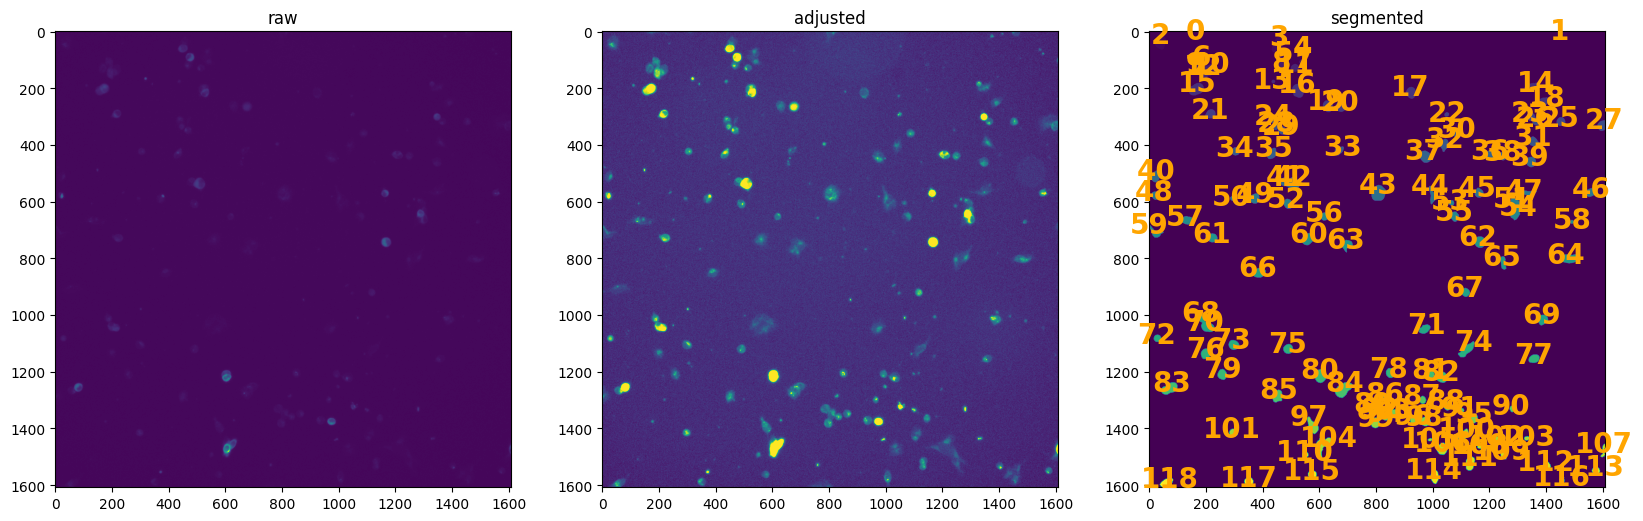

In [8]:
# cell segmentation

# plot raw data
plt.figure(figsize=(20,10))
ax1=plt.subplot(131)
ax1.imshow(data)
ax1.set_title('raw')

# adjust contrast for better segmentation using percentile rescaling
percentiles = np.percentile(data, (0.5, 99.5))
dataAdjusted = exposure.rescale_intensity(data,in_range=tuple(percentiles))

# plot adjusted data
ax2=plt.subplot(132)
ax2.set_title('adjusted')
ax2.imshow(dataAdjusted)

# run cellpose
masks, flows, styles, diams = model.eval(dataAdjusted, diameter=None,do_3D=False,)
np.set_printoptions(threshold=sys.maxsize)

# plot cellposed data
ax3=plt.subplot(133)
ax3.set_title('segmented')
ax3.imshow(masks)

# label individual cells

labels=[]
for i in range(masks.shape[0]):
    for j in range(masks.shape[1]):
        if masks[i][j]==0:
            continue
        else:
            if masks[i][j] not in labels:
                labels.append(masks[i][j])
                ax3.text(j, i, int(masks[i][j])-1,ha="center", va="center", fontsize=20, fontweight='black',color='orange')


In [10]:


# stupid way to get area by iterating through all pixel points
# could use improvement
# maybe use a dictionary for cell indexing
"""
# get area for each cell
numOfCells=np.max(masks)
areas=[]
for i in range(1,numOfCells+1):
    count=0
    for j in range(masks.shape[0]):
        for k in range(masks.shape[1]):
            if masks[j][k]==i:
                count+=1
    if iter == 0:
        continue
    areas.append(count)
"""

'\n# get area for each cell\nnumOfCells=np.max(masks)\nareas=[]\nfor i in range(1,numOfCells+1):\n    count=0\n    for j in range(masks.shape[0]):\n        for k in range(masks.shape[1]):\n            if masks[j][k]==i:\n                count+=1\n    if iter == 0:\n        continue\n    areas.append(count)\n'

In [11]:
# get coordinates for each cell
numOfCells = np.max(masks)
indices=[]
areas=[]

for i in range(1,numOfCells+1):
    index=np.argwhere(masks==i)
    area=len(index)
    indices.append(index) 
    areas.append(area)

indices = np.array(indices, dtype= object)
areas = np.array(areas, dtype= object)

In [12]:
# convert masks to binary format
newMasks=np.zeros_like(masks,int)
newMasks[masks>=1]=1   

for key,channel in channels.items():
    result = channel.raw*newMasks[None,:,:]    
    channel.masked = result
    channel.stacked=newMasks             


In [13]:
# store segmentation info as region_cells using cellProp object    
region_cells=[]
for i in range(numOfCells):
    prop=cellProp(indices[i],areas[i])
    region_cells.append(prop)

channels['channel1'].region_cells=region_cells
channels['channel2'].region_cells=region_cells

### Isolate cells/record transients 
Gets transients for all cell-like objects (selection criteria come after this function) 


In [14]:
# get time series data for each cell in each channel
# saved as channel.traces
for key in channels.keys():
    channel = channels[key]
    traces, region_cells_MASTER = transients.GetTraces(
                channel.masked, # time-series data after masking 
                channel.stacked,# mask 
                region_cells=channel.region_cells,
                channelName=channel.index)
    channel.traces = traces
    channel.region_cells = region_cells

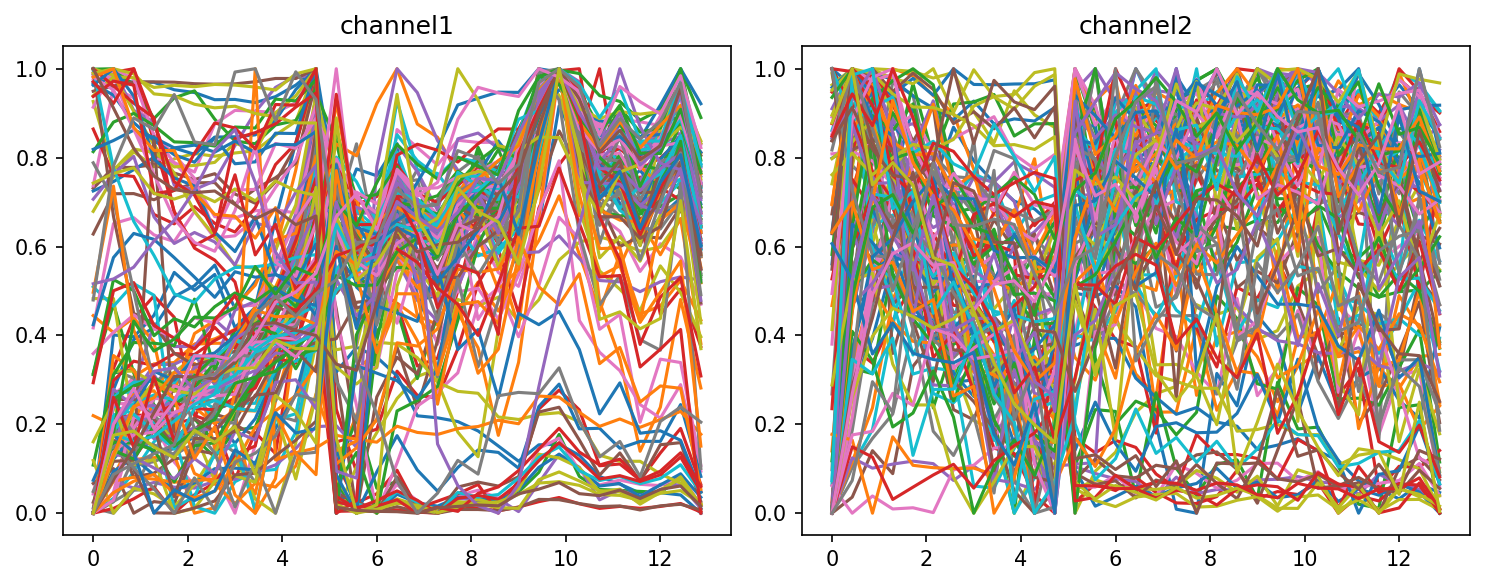

In [17]:
# get Ca transient traces
normalize=False
nTrace=len(channels['channel1'].traces)
nTimePts=len(channels['channel1'].traces[0])
frameRate=25 # sec/frame 
ts=np.linspace(0,frameRate*nTimePts/60,nTimePts)
start=0
end=30

rcParams['figure.figsize']=10,4
rcParams['figure.dpi']=150
fig=plt.figure()

for i,key in enumerate(channels.keys()):
    channel=channels[key]
    ax=fig.add_subplot(1,2,i+1)
    ax.set_title(key)
    
    for j in range(nTrace):
        trace=channel.traces[j]
        
        if normalize:
            trace-=np.min(trace)
            trace/=np.max(trace)
        
        ax.plot(ts[start:end+1],trace[start:end+1])
        
plt.tight_layout()
        

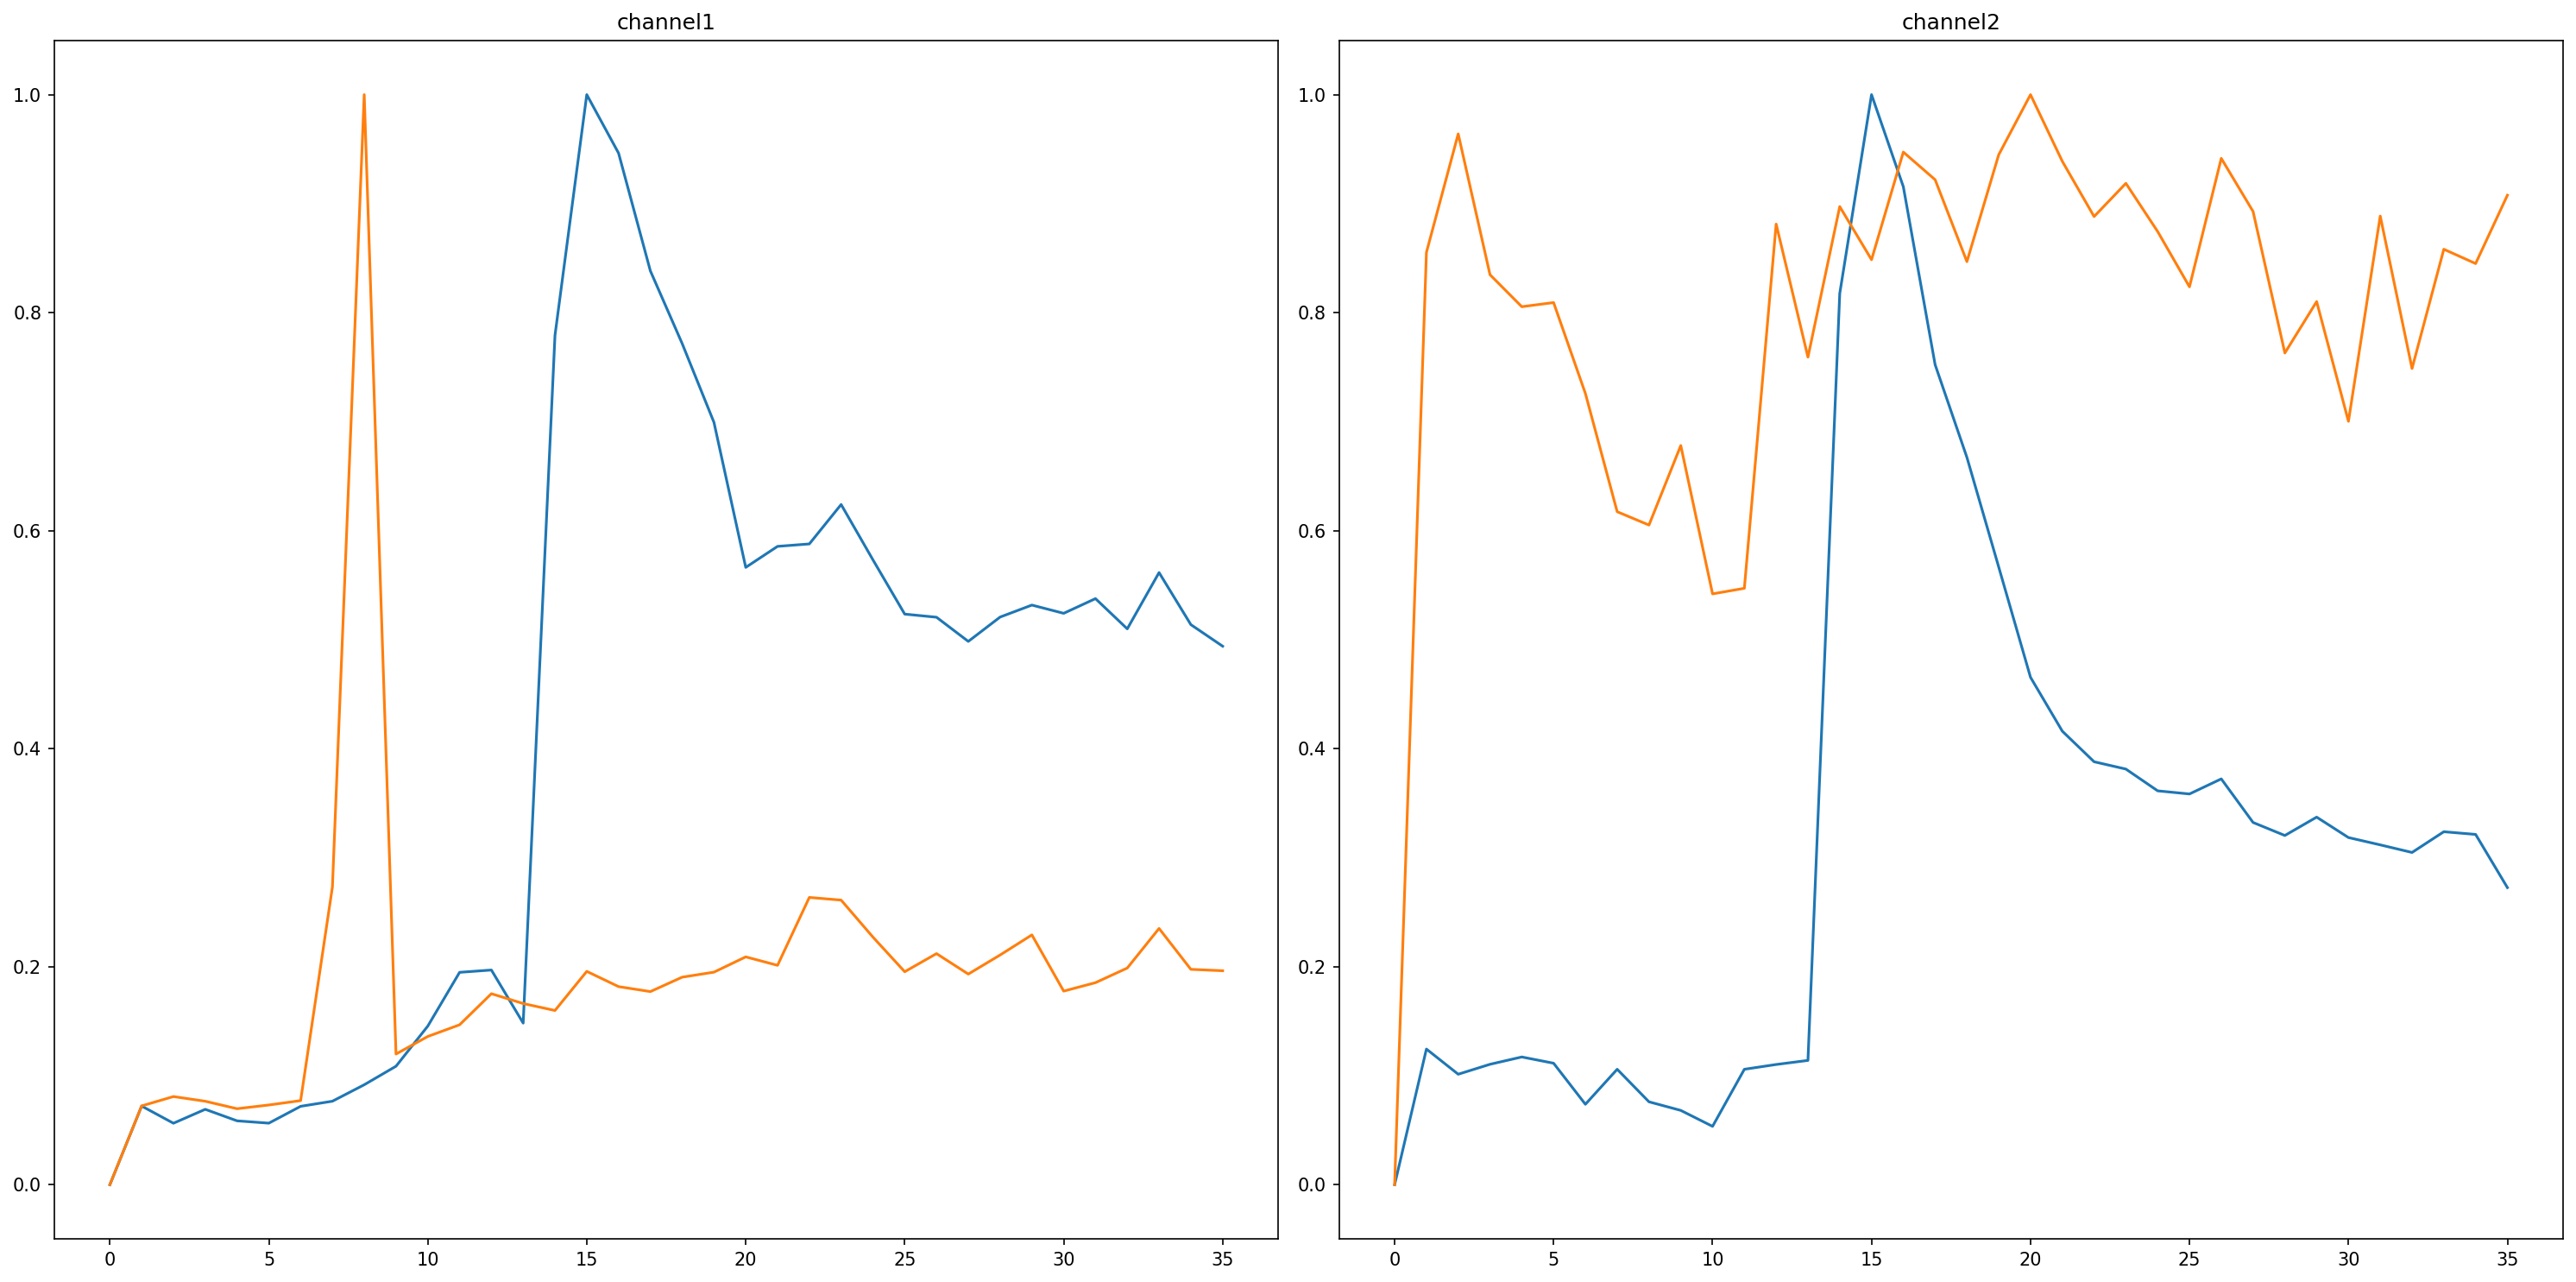

In [16]:
# try different criteria to screen for traces that make biological sense

# Screen out cells that do not meet the criteria (semi-subjective process)
channel = channels['channel1']
channel.minCellSize = 10
channel.maxCellSize = None
channel.minFluctuation = 20

newTracesMap = transients.ScreenTraces(
    channel.traces,
    region_cells_MASTER,       # changed from "channel.region_cells" to "region_cells_MASTER"                         
    minCellSize = channel.minCellSize,
    maxCellSize = channel.maxCellSize,
    minFluctuation = channel.minFluctuation, # base on intensity 
    #minDerivative = channel.minDerivative # based on derivative (looking for rapid upswing, not slow increase)                 
)

normalize=True
rcParams['figure.figsize']=20,10
fig=plt.figure()

for i,key in enumerate(channels.keys()):
    channel=channels[key]
    ax=fig.add_subplot(1,2,i+1)
    ax.set_title(key)

    for j in newTracesMap:
        trace=np.copy(channel.traces[j])

        if normalize:
            trace-=np.min(trace)
            trace/=np.max(trace)

        ax.plot(trace)

plt.tight_layout()